# XGboost

#### I want to se how XGboost performs on a large dataset predicting just a day ahead


In [12]:
import wapi # wattsights egen pakke / den må installers via `pip install wapi-python`
import pandas as pd
import os
import numpy as np
from datetime import datetime 
from datetime import timedelta

# Create a session
# Dette forutsetter at dere har lagret volue credentials som miljøvariabler på PC'en deres og med navnet `WS_CLIENT_ID` og `WS_CLIENT_SECRET`
user = os.getenv("WS_CLIENT_ID")
password = os.getenv("WS_CLIENT_SECRET")
session = wapi.Session(client_id=user, client_secret=password)

start = '2020-01-01'
end = '2021-01-01'
periods=pd.date_range(start,end,freq='D')

curves = ['con no1 mwh/h cet min15 a',
'tt no1 con ec00 °c cet min15 f',
"cc no1 con ec00 % cet min15 f",
"con no1 ec00 mwh/h cet min15 f"
]

df_watt = pd.DataFrame()
for curve in curves:
    print(f"Working with {curve}")
    curve = session.get_curve(name=curve)
    curve_type = curve.curve_type
    res = []
    counter = 1
    if curve_type == 'TIME_SERIES':
        ts = curve.get_data(data_from=start, data_to=end, function='SAVERAGE', frequency='H')
        watt_temp = ts.to_pandas()
        df_watt = pd.merge(df_watt, watt_temp, left_index=True, right_index=True, how='outer')
        continue
    
    for j in range(len(periods)):
        if j == len(periods)-1:
            continue
        if curve_type == 'TAGGED_INSTANCES':
            ts_list = curve.search_instances(issue_date_from=periods[j],
                                 issue_date_to=periods[j+1],
                                 with_data=True, function='SAVERAGE', frequency='H', tags=['Avg'])
        else: #curve_type == 'INSTANCES'
            ts_list = curve.search_instances(issue_date_from=periods[j],
                                 issue_date_to=periods[j+1],
                                 with_data=True, function='SAVERAGE', frequency='H')
        # check if ts_list is empty and if yes, jump over that timestamp
        if not ts_list:
            continue
        pd_s = ts_list[0].to_pandas()
        if pd_s.empty:
            continue
        pd_s = pd_s.sort_index(ascending=True)
        pd_s = pd_s[:24]
        res.append(pd_s)
        print(f'Done {counter} out of {len(periods)}')
        counter += 1

    for k in range(len(res)):
        if k == 0:
            watt = pd.Series(res[k])
        else:
            watt = pd.concat([watt, res[k]])
    watt_temp = watt.rename(curve)
    df_watt = pd.merge(df_watt, watt_temp, left_index=True, right_index=True, how='outer')


Working with con no1 mwh/h cet min15 a
Working with tt no1 con ec00 °c cet min15 f
Done 1 out of 367
Done 2 out of 367
Done 3 out of 367
Done 4 out of 367
Done 5 out of 367
Done 6 out of 367
Done 7 out of 367
Done 8 out of 367
Done 9 out of 367
Done 10 out of 367
Done 11 out of 367
Done 12 out of 367
Done 13 out of 367
Done 14 out of 367
Done 15 out of 367
Done 16 out of 367
Done 17 out of 367
Done 18 out of 367
Done 19 out of 367
Done 20 out of 367
Done 21 out of 367
Done 22 out of 367
Done 23 out of 367
Done 24 out of 367
Done 25 out of 367
Done 26 out of 367
Done 27 out of 367
Done 28 out of 367
Done 29 out of 367
Done 30 out of 367
Done 31 out of 367
Done 32 out of 367
Done 33 out of 367
Done 34 out of 367
Done 35 out of 367
Done 36 out of 367
Done 37 out of 367
Done 38 out of 367
Done 39 out of 367
Done 40 out of 367
Done 41 out of 367
Done 42 out of 367
Done 43 out of 367
Done 44 out of 367
Done 45 out of 367
Done 46 out of 367
Done 47 out of 367
Done 48 out of 367
Done 49 out of

In [13]:
import holidays
from datetime import date
no_holidays = holidays.NO()
d = np.zeros(len(periods))

for l in range(len(periods)):
    a = str(int(periods[l].strftime('%Y%m%d')))

    da = int(a[-2:])
    mo = int(a[-4:-2])
    yr = int(a[-8:-4])
    if date(yr,mo,da) in no_holidays:            
        d[l] = 1

df = pd.DataFrame(d,index=[i for i in periods],columns=['weekend?'])
df.index = pd.to_datetime(df.index).tz_localize('Etc/UCT')

df_watt = pd.merge(df_watt, df, left_index=True, right_index=True, how='outer')

df_watt.columns = ["cons_actual", "temp_forecast", "cloud_cover", "cons_forecast", "weekend?"]
df_watt.dropna(inplace=True)
df_watt.to_csv("holiday_test.zip")
df_watt

,cons_actual,temp_forecast,cloud_cover,cons_forecast,weekend?
2020-01-01 00:00:00+00:00,4360.496222,2.6,1.00,4326.677725,1.0
2020-01-02 00:00:00+00:00,4263.700281,2.6,0.98,4329.109649,0.0
2020-01-03 00:00:00+00:00,4048.106365,5.9,1.00,4194.425370,0.0
2020-01-04 00:00:00+00:00,4560.874038,0.1,0.09,4377.051579,0.0
2020-01-05 00:00:00+00:00,4690.272096,-1.9,0.92,4804.856453,0.0
...,...,...,...,...,...
2020-12-27 00:00:00+00:00,4404.000000,2.9,1.00,4395.773985,0.0
2020-12-28 00:00:00+00:00,4691.000000,0.8,1.00,4207.628664,0.0
2020-12-29 00:00:00+00:00,4491.000000,0.9,1.00,4333.503648,0.0
2020-12-30 00:00:00+00:00,4495.000000,1.3,1.00,4419.529596,0.0


In [14]:
df_watt
# df_watt.columns = ["cons_actual", "temp_forecast", "cloud_cover", "cons_forecast"]

,cons_actual,temp_forecast,cloud_cover,cons_forecast,weekend?
2020-01-01 00:00:00+00:00,4360.496222,2.6,1.00,4326.677725,1.0
2020-01-02 00:00:00+00:00,4263.700281,2.6,0.98,4329.109649,0.0
2020-01-03 00:00:00+00:00,4048.106365,5.9,1.00,4194.425370,0.0
2020-01-04 00:00:00+00:00,4560.874038,0.1,0.09,4377.051579,0.0
2020-01-05 00:00:00+00:00,4690.272096,-1.9,0.92,4804.856453,0.0
...,...,...,...,...,...
2020-12-27 00:00:00+00:00,4404.000000,2.9,1.00,4395.773985,0.0
2020-12-28 00:00:00+00:00,4691.000000,0.8,1.00,4207.628664,0.0
2020-12-29 00:00:00+00:00,4491.000000,0.9,1.00,4333.503648,0.0
2020-12-30 00:00:00+00:00,4495.000000,1.3,1.00,4419.529596,0.0


## Preprocessing

In [15]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt

from xgboost import XGBRegressor
from pandasql import sqldf
pysqldf = lambda q: sqldf(q,globals())
from sklearn.model_selection import train_test_split

#### Adding Day- and Week- cos and sin

In [16]:
df_watt['Seconds'] = df_watt.index.map(pd.Timestamp.timestamp)
day = 60*60*24
year = 365.2425*day
week = day*7

df_watt['Day sin'] = np.sin(df_watt['Seconds'] * (2* np.pi / day))
df_watt['Day cos'] = np.cos(df_watt['Seconds'] * (2 * np.pi / day))
df_watt['Week sin'] = np.sin(df_watt['Seconds'] * (2 * np.pi / week))
df_watt['Week cos'] = np.cos(df_watt['Seconds'] * (2 * np.pi / week))
df_watt['Year sin'] = np.sin(df_watt['Seconds'] * (2 * np.pi / year))
df_watt['Year cos'] = np.cos(df_watt['Seconds'] * (2 * np.pi / year))

df_watt=df_watt.drop(['Seconds'], axis=1)
df_watt

,cons_actual,temp_forecast,cloud_cover,cons_forecast,weekend?,Day sin,Day cos,Week sin,Week cos,Year sin,Year cos
2020-01-01 00:00:00+00:00,4360.496222,2.6,1.00,4326.677725,1.0,-7.670342e-12,1.0,-7.818315e-01,0.623490,-0.002150,0.999998
2020-01-02 00:00:00+00:00,4263.700281,2.6,0.98,4329.109649,0.0,-3.371804e-12,1.0,-1.001397e-12,1.000000,0.015052,0.999887
2020-01-03 00:00:00+00:00,4048.106365,5.9,1.00,4194.425370,0.0,9.267350e-13,1.0,7.818315e-01,0.623490,0.032250,0.999480
2020-01-04 00:00:00+00:00,4560.874038,0.1,0.09,4377.051579,0.0,-9.326642e-12,1.0,9.749279e-01,-0.222521,0.049438,0.998777
2020-01-05 00:00:00+00:00,4690.272096,-1.9,0.92,4804.856453,0.0,-5.028103e-12,1.0,4.338837e-01,-0.900969,0.066611,0.997779
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27 00:00:00+00:00,4404.000000,2.9,1.00,4395.773985,0.0,-1.295283e-11,1.0,4.338837e-01,-0.900969,-0.075062,0.997179
2020-12-28 00:00:00+00:00,4691.000000,0.8,1.00,4207.628664,0.0,-8.654291e-12,1.0,-4.338837e-01,-0.900969,-0.057898,0.998323
2020-12-29 00:00:00+00:00,4491.000000,0.9,1.00,4333.503648,0.0,-4.355752e-12,1.0,-9.749279e-01,-0.222521,-0.040716,0.999171
2020-12-30 00:00:00+00:00,4495.000000,1.3,1.00,4419.529596,0.0,-5.721331e-14,1.0,-7.818315e-01,0.623490,-0.023523,0.999723


In [ ]:
df_watt

,cons_actual,temp_forecast,cloud_cover,cons_forecast,Day sin,Day cos,Week sin,Week cos,Year sin,Year cos
2020-01-01 00:00:00+01:00,4330.160371,5.7,0.93,4315.219520,-2.588190e-01,9.659258e-01,-0.804598,0.593820,-2.867126e-03,0.999996
2020-01-01 01:00:00+01:00,4165.265143,5.7,0.95,4231.366035,-7.670342e-12,1.000000e+00,-0.781831,0.623490,-2.150345e-03,0.999998
2020-01-01 02:00:00+01:00,4140.002008,6.0,0.77,4159.397837,2.588190e-01,9.659258e-01,-0.757972,0.652287,-1.433564e-03,0.999999
2020-01-01 03:00:00+01:00,4056.170267,5.7,0.82,4128.932301,5.000000e-01,8.660254e-01,-0.733052,0.680173,-7.167823e-04,1.000000
2020-01-01 04:00:00+01:00,4058.099530,5.6,0.88,4143.490198,7.071068e-01,7.071068e-01,-0.707107,0.707107,1.964387e-15,1.000000
...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00+01:00,5190.000000,0.0,0.96,5333.830046,-1.000000e+00,-3.448707e-12,0.623490,0.781831,6.580015e-03,0.999978
2020-12-31 20:00:00+01:00,5029.000000,-0.1,0.93,5244.874870,-9.659258e-01,2.588190e-01,0.652287,0.757972,7.296780e-03,0.999973
2020-12-31 21:00:00+01:00,4916.000000,-0.2,0.90,5143.341786,-8.660254e-01,5.000000e-01,0.680173,0.733052,8.013541e-03,0.999968
2020-12-31 22:00:00+01:00,4802.000000,-0.2,0.84,4999.280754,-7.071068e-01,7.071068e-01,0.707107,0.707107,8.730298e-03,0.999962


## Lets see how correlated these values are

In [17]:
corr_matrix = df_watt.corr()
corr_matrix

,cons_actual,temp_forecast,cloud_cover,cons_forecast,weekend?,Day sin,Day cos,Week sin,Week cos,Year sin,Year cos
cons_actual,1.000000,-0.892389,0.184290,0.988244,0.018829,-0.010488,NaN,0.026083,0.032451,0.326940,0.896140
temp_forecast,-0.892389,1.000000,0.003760,-0.883974,-0.089082,0.002745,NaN,-0.024462,-0.029083,-0.486259,-0.690183
cloud_cover,0.184290,0.003760,1.000000,0.210813,-0.019431,0.083011,NaN,-0.044992,-0.035216,-0.108288,0.282517
cons_forecast,0.988244,-0.883974,0.210813,1.000000,0.015551,0.016230,NaN,0.045358,0.027237,0.334984,0.896777
weekend?,0.018829,-0.089082,-0.019431,0.015551,1.000000,-0.000812,NaN,0.065123,-0.006213,0.152144,-0.029347
Day sin,-0.010488,0.002745,0.083011,0.016230,-0.000812,1.000000,NaN,-0.001043,0.001733,0.017014,0.006177
Day cos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Week sin,0.026083,-0.024462,-0.044992,0.045358,0.065123,-0.001043,NaN,1.000000,-0.002645,0.000131,-0.004264
Week cos,0.032451,-0.029083,-0.035216,0.027237,-0.006213,0.001733,NaN,-0.002645,1.000000,0.000017,0.008837
Year sin,0.326940,-0.486259,-0.108288,0.334984,0.152144,0.017014,NaN,0.000131,0.000017,1.000000,-0.000017


### An autocorrelation plot might be more interesting

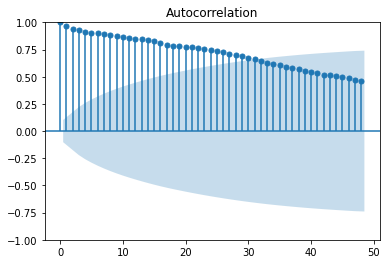

In [18]:
from statsmodels.graphics import tsaplots

# Display the autocorrelation plot of your time series
fig1 = tsaplots.plot_acf(df_watt['cons_actual'], lags=48)
plt.show()

#### As we might have expected, the autocorrelation is high when the lag is around < 6 or 7 and between 20 to 30. 
##### The reason this is expected is because lag is corresponding to a time interval (hours) and we expect a daily pattern that differs from the night, since this is showing the electricity consumption

In [19]:
cols = list(df_watt)[0:11]
#New dataframe with only training data - 4 columns
df_for_training = df_watt[cols].astype(float)
df_for_training

,cons_actual,temp_forecast,cloud_cover,cons_forecast,weekend?,Day sin,Day cos,Week sin,Week cos,Year sin,Year cos
2020-01-01 00:00:00+00:00,4360.496222,2.6,1.00,4326.677725,1.0,-7.670342e-12,1.0,-7.818315e-01,0.623490,-0.002150,0.999998
2020-01-02 00:00:00+00:00,4263.700281,2.6,0.98,4329.109649,0.0,-3.371804e-12,1.0,-1.001397e-12,1.000000,0.015052,0.999887
2020-01-03 00:00:00+00:00,4048.106365,5.9,1.00,4194.425370,0.0,9.267350e-13,1.0,7.818315e-01,0.623490,0.032250,0.999480
2020-01-04 00:00:00+00:00,4560.874038,0.1,0.09,4377.051579,0.0,-9.326642e-12,1.0,9.749279e-01,-0.222521,0.049438,0.998777
2020-01-05 00:00:00+00:00,4690.272096,-1.9,0.92,4804.856453,0.0,-5.028103e-12,1.0,4.338837e-01,-0.900969,0.066611,0.997779
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27 00:00:00+00:00,4404.000000,2.9,1.00,4395.773985,0.0,-1.295283e-11,1.0,4.338837e-01,-0.900969,-0.075062,0.997179
2020-12-28 00:00:00+00:00,4691.000000,0.8,1.00,4207.628664,0.0,-8.654291e-12,1.0,-4.338837e-01,-0.900969,-0.057898,0.998323
2020-12-29 00:00:00+00:00,4491.000000,0.9,1.00,4333.503648,0.0,-4.355752e-12,1.0,-9.749279e-01,-0.222521,-0.040716,0.999171
2020-12-30 00:00:00+00:00,4495.000000,1.3,1.00,4419.529596,0.0,-5.721331e-14,1.0,-7.818315e-01,0.623490,-0.023523,0.999723


#### Normalizing the data is not necessary for XGboost

#### Reshape the data
###### Tester om XGboost trenger cos og sin

In [20]:
train_df, test_df = df_for_training[:47000],df_for_training[47000:]
test_df_2 = df_for_training[46500:47000]
X_parameter = ["temp_forecast", "cloud_cover", "Day sin", "Day cos", "Week cos","Week sin"]
X_parameter_2 = ["temp_forecast","Week sin","Week cos", "cloud_cover"]
X_train, X_test, Y_train, Y_test = train_df[X_parameter], test_df[X_parameter], train_df["cons_actual"], test_df["cons_actual"]
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_df[X_parameter_2], test_df[X_parameter_2], train_df["cons_actual"], test_df["cons_actual"]
X_test_3, Y_test_3 = test_df_2[X_parameter], test_df_2["cons_actual"]
#Merk at train_test_split henter data randome, og kan ikke brukes
#Valgte her å splitte ved 2000, så trener på 2000 verdier og tester på 172
df_for_training.shape

# print(X_train)
print(X_test)
# print(Y_train)
# print(Y_test)

Empty DataFrame
Columns: [temp_forecast, cloud_cover, Day sin, Day cos, Week cos, Week sin]
Index: []


##### Har fått info om at XGBoost ikke burde ta inn cos og sin, men observerer at uten de blir modellen dårligere, så burde være med

### Her er det mulig å tilpasse n_estiamtors, learning_rate og max_depth
##### n_estimators vil øke accuracy lineært i starten, men vil etterhvert komme til et knekkningspunkt der verdien blir konstant
##### max_depth verdi mellom 1-9, antall layers. For dype trær fanger for mange detaljer og overfiter. Default er 3, max_depth
##### learning_rate fort overfitting vanlig 0.1-0.3 vil også bli konstant etter oppnåd en verdi
##### Virker som mulighet for å legge in es - early stopping her å

In [21]:
#reg_2 = XGBRegressor(n_estimators = 400, learning_rate =0.1, max_depth = 5)
#reg_2.fit(X_train_2,Y_train_2, eval_set=[(X_train_2,Y_train_2),(X_test_2,Y_test_2)], eval_metric="mae")

reg_3 = XGBRegressor(n_estimators = 400, learning_rate = 0.3, max_depth = 3)
reg_3.fit(X_train,Y_train, eval_set=[(X_train,Y_train),(X_test,Y_test)], eval_metric="mae", early_stopping_rounds=5)

reg = XGBRegressor(n_estimators = 1000, learning_rate =0.1, max_depth = 3)
reg.fit(X_train,Y_train, eval_set=[(X_train,Y_train),(X_test,Y_test)], eval_metric="mae", early_stopping_rounds=5)

[14:58:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[14:58:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[0]	validation_0-mae:2344.30296	validation_1-mae:0.00000
[14:58:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[14:58:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[1]	validation_0-mae:1650.05892	validation_1-mae:0.00000
[14:58:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[14:58:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[2]	validation_0-mae:1162.81039	validation_1-mae:0.00000
[14:58:50] WARNING: C:/Users/Administrator/workspace/xg

c:\Users\57861\.conda\envs\p39_sommer\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\57861\.conda\envs\p39_sommer\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [22]:
prediction = reg.predict(X_test)
# prediction_2 = reg_2.predict(X_test_2)
prediction_3 = reg_3.predict(X_test)
date = df_watt.index.to_frame()
date_train, date_test, date_3 = date[:47000], date[47000:], date[46500:47000]

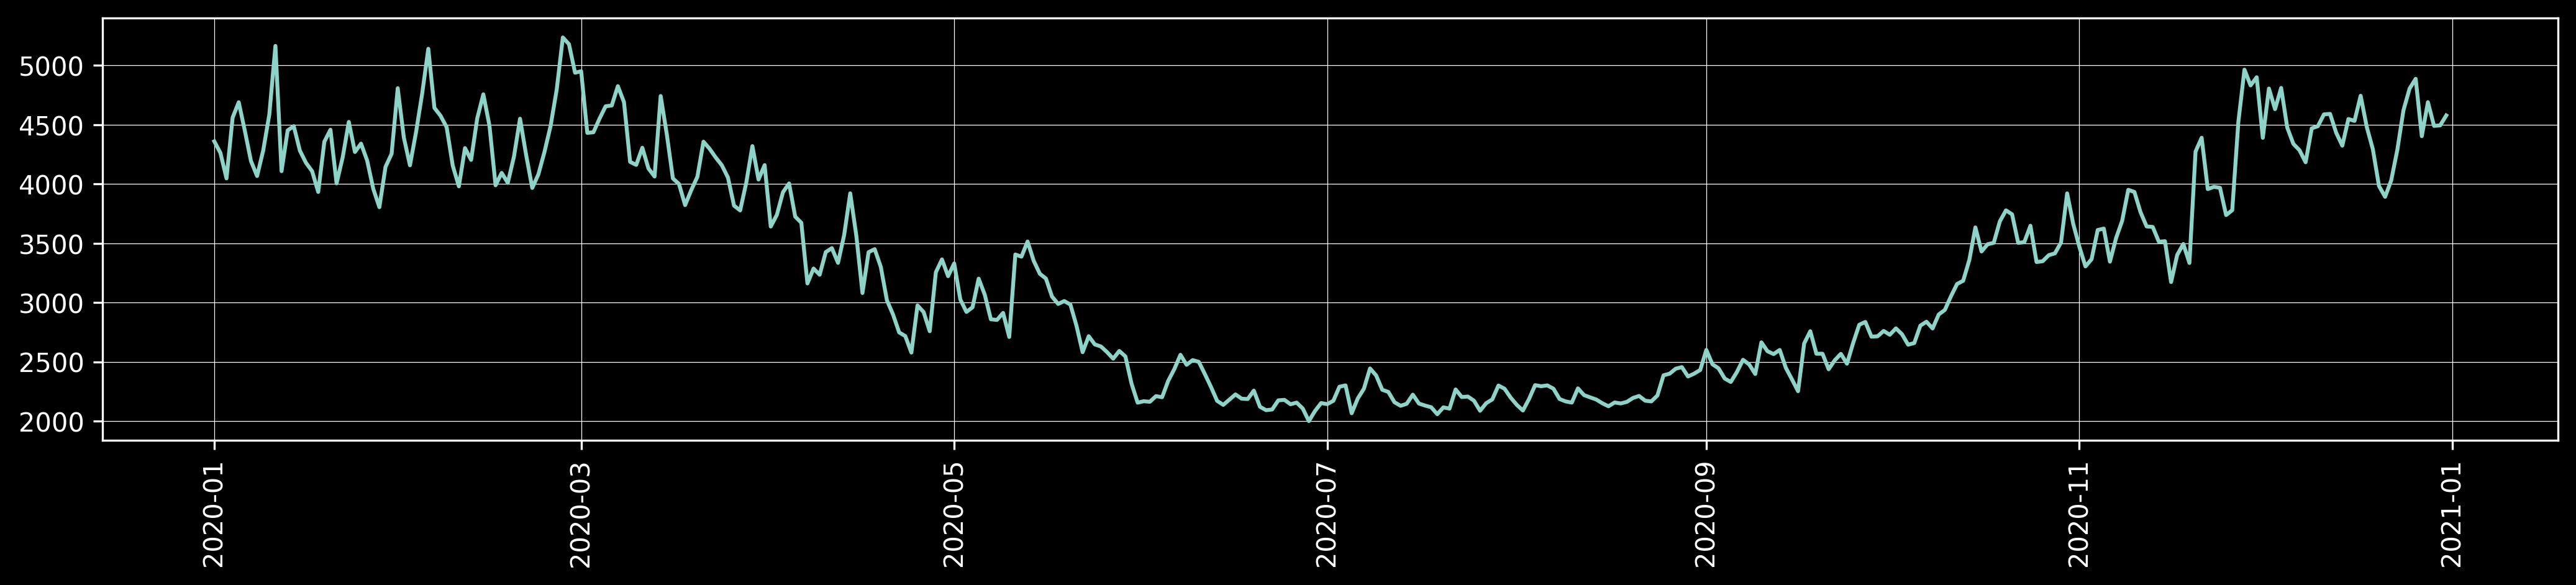

In [23]:
plt.style.use('dark_background')
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
plt.plot(date,df_for_training["cons_actual"])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [24]:
print(prediction)

[]


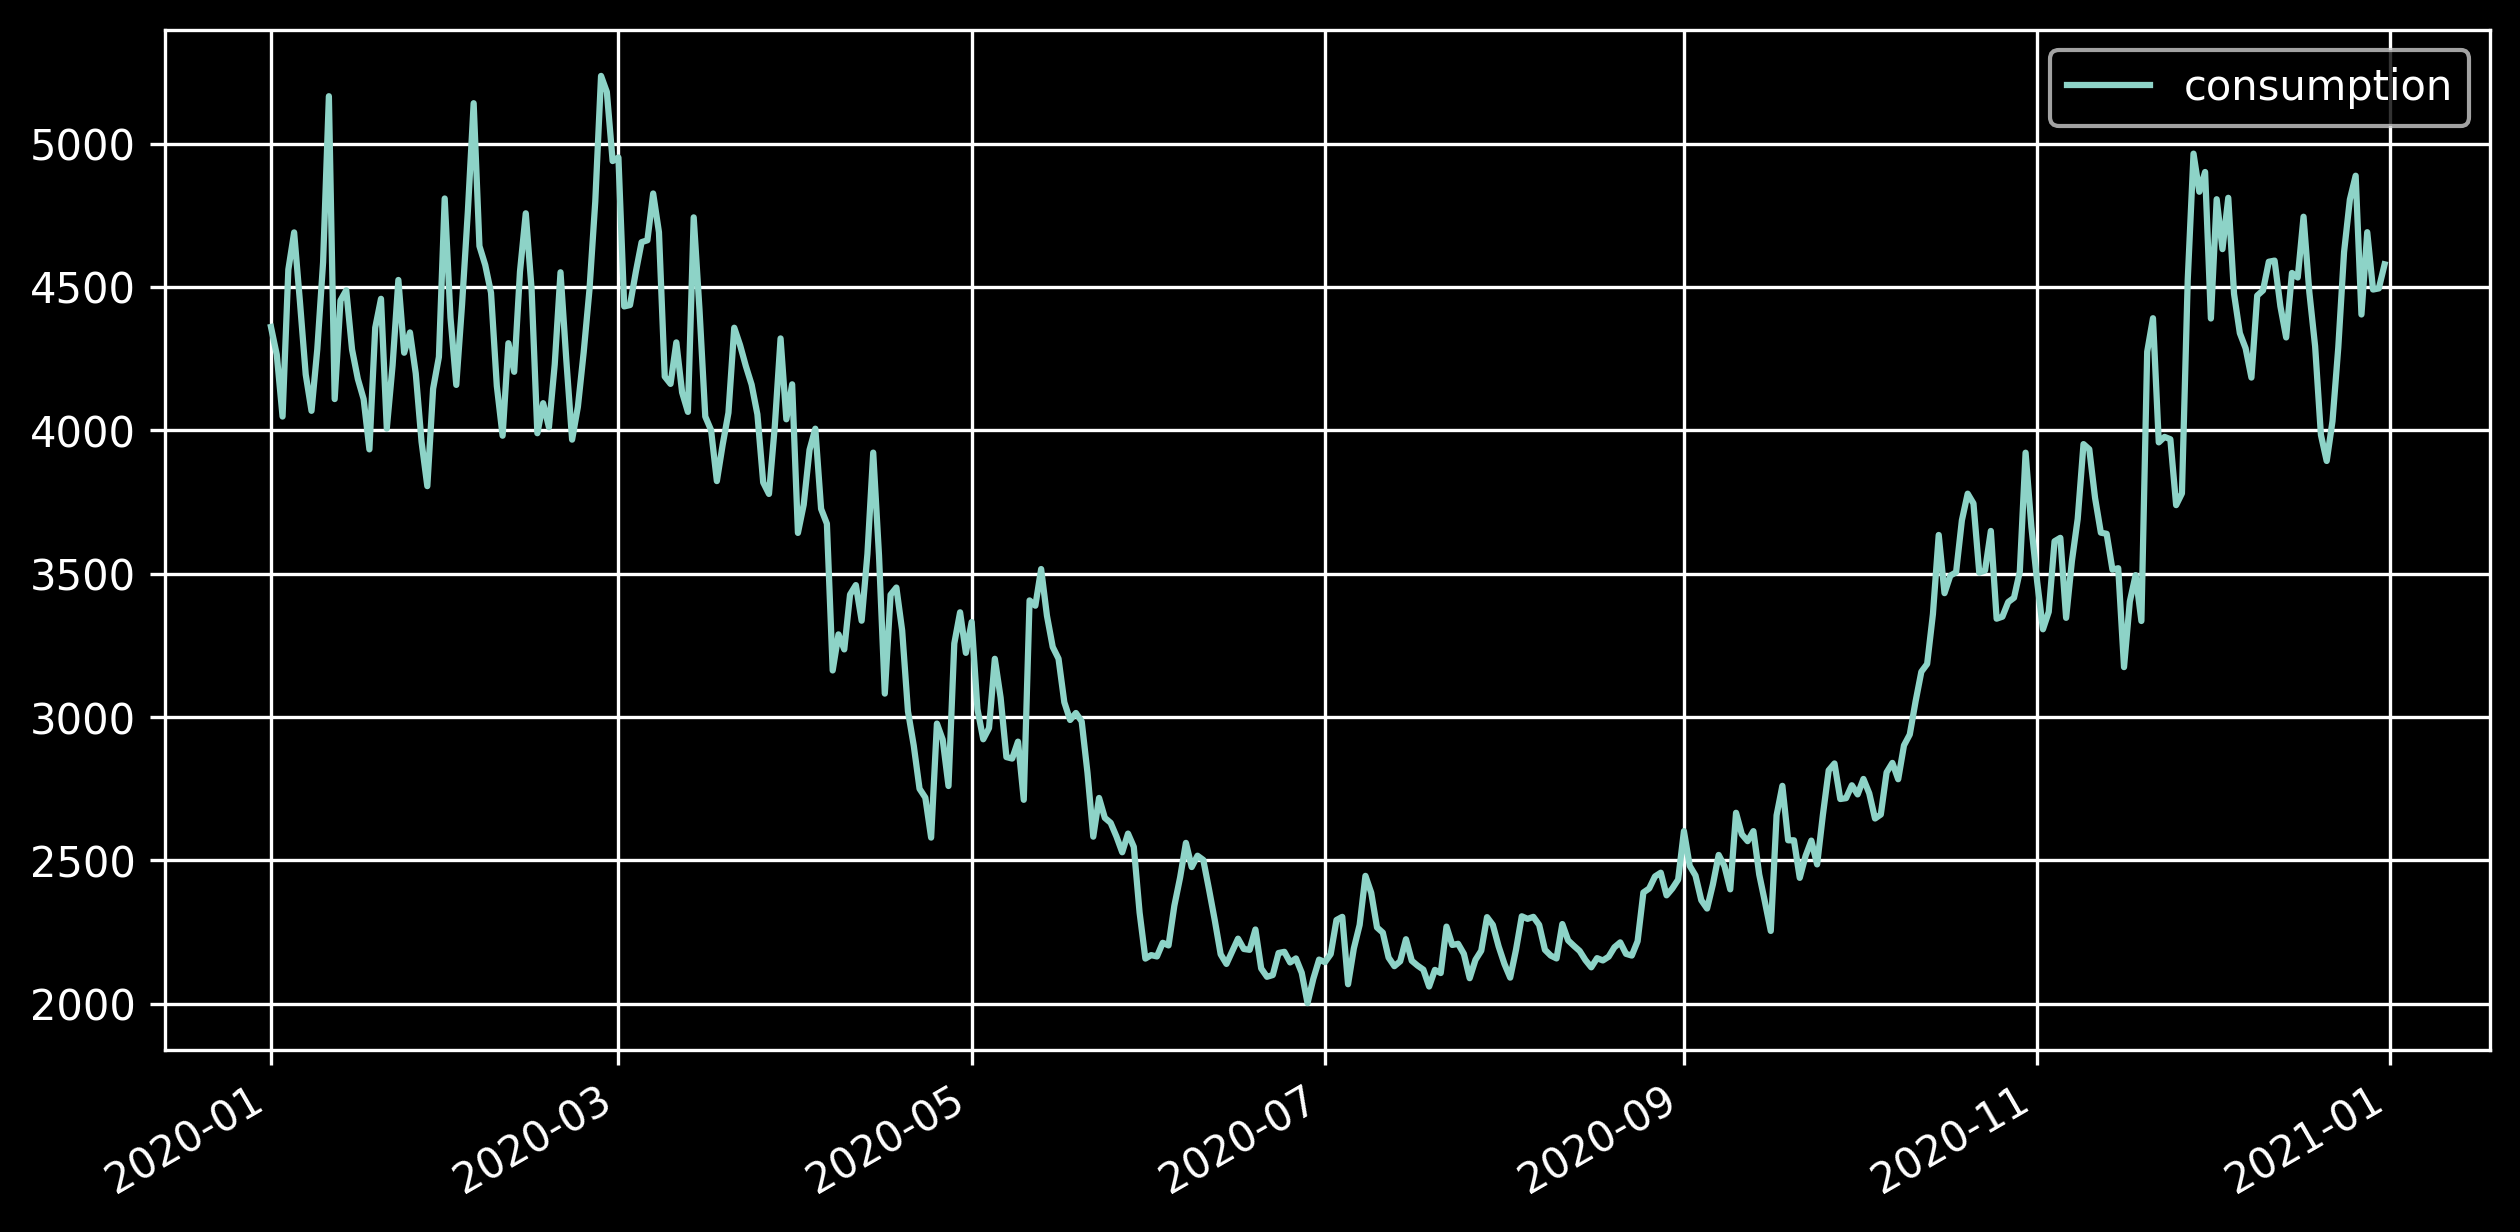

In [25]:
plt.figure(figsize=(10,5))
plt.plot(date,df_for_training['cons_actual'], label = "consumption")
#plt.plot(date_test, (prediction+150), label='prediction + 150')
plt.plot(date_test, prediction, label='prediction')
#plt.plot(date_test, prediction_2, label = "prediction without sin and cos")
#plt.plot(date_test, prediction_3, label = "prediction learning = 0.3")
#Beautify x-axis
plt.grid()
plt.xticks(rotation=90)
plt.gcf().autofmt_xdate()

plt.legend()
plt.show()

In [ ]:
reg.feature_importances_

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)